# ### A complete tutorial 
In addition to the functions introduced in the basic tutorial, toad provides rather comprehensive toolkit to the entire modelling procedure. As a project initially incubated within a fintech firm, the applicability and reliability has been verified.

This tutorial will demonstrate the applicabilty of toad according to different modelling procedure or scenario.

**1. Fine tuning bins**

**2. Model validation**

**3. Feature selection**

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import toad

### 0. Prepare demo data

In [3]:
data = pd.read_csv('germancredit.csv')
data.replace({'good':0,'bad':1},inplace=True) # replace target as 0, 1. 

Xtr,Xts,Ytr,Yts = train_test_split(data.drop('creditability',axis=1),data['creditability'],test_size=0.25,random_state=450)
data_tr = pd.concat([Xtr,Ytr],axis=1)
data_tr['type'] = 'train' # A new feature to indicate test/training sample
data_ts = pd.concat([Xts,Yts],axis=1)
data_ts['type'] = 'test'

# The training set will be used for modelling and the test set will only be used for validation. 

print(data_tr.shape)
#print(data_tr.head())

(750, 22)


### ### 1. Fine tune bins 
Tuning bins is a common and very important practice in industry modelling. The quality of bins accounts for both preditability and stability. In the following, we will introduce how to use toad to fine tune bins. 

We will fine tune a numerical feature (e.g. 'duration.in.month') and a categorical feature ('purpose'). 

In [8]:
data_tr2 = data_tr[['duration.in.month','purpose','creditability']]

** **Basics****

combiner.fit(X, y  = 'target', method = 'chi', min_samples = None, n_bins = None, return_splits=False) 

Binning method supports: 'chi' (chi-squared), 'dt' (decision tree), 'quantile' (quantile), 'step' (step), and 'kmeans' (k-means). 

** **Tips: (1) chi-squared binning provides reliable results; (2) adding min_samples = 0.05 is strongly recommended** **

In [5]:
combiner = toad.transform.Combiner()
combiner.fit(data_tr2,y='creditability',method='chi',min_samples = 0.05)
combiner.export()

{'duration.in.month': [9, 12, 18, 33],
 'purpose': [['domestic appliances', 'car (used)', 'retraining'],
  ['radio/television'],
  ['furniture/equipment'],
  ['repairs', 'business', 'car (new)'],
  ['education', 'others']]}

** **Tips: use bin_plot() to check the quality of the current bins and make fine adjustment accordingly** ** 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


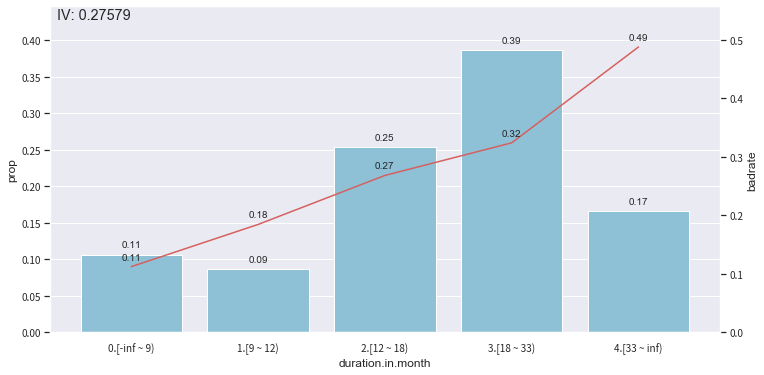

In [9]:
from toad.plot import bin_plot

transformed = combiner.transform(data_tr2,labels=True) # the data sent to the bin_plot() must be binning transformed
bin_plot(transformed,x='duration.in.month',target='creditability')

** **Trick: fine tune bins without setting min_samples** **

Without setting min_samples, the combiner() function, by default, seperates data into 10 bins only based on min_threshold ("chi" method). The result cannot be used directly. But, as more thresholds are determined, there's larger room to make adjustment. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
{'duration.in.month': [9, 10, 12, 13, 16, 18, 33, 39, 40]}


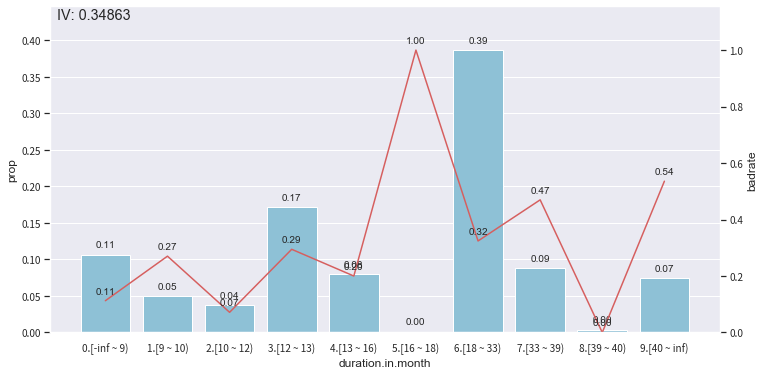

In [11]:
# initialise a new combiner() for experiments.
c2 = toad.transform.Combiner()
c2.fit(data_tr2[['duration.in.month','creditability']],y='creditability',method='chi')
bin_plot(c2.transform(data_tr2[['duration.in.month','creditability']],labels=True),x='duration.in.month',target='creditability')
print(c2.export())

No handles with labels found to put in legend.
No handles with labels found to put in legend.


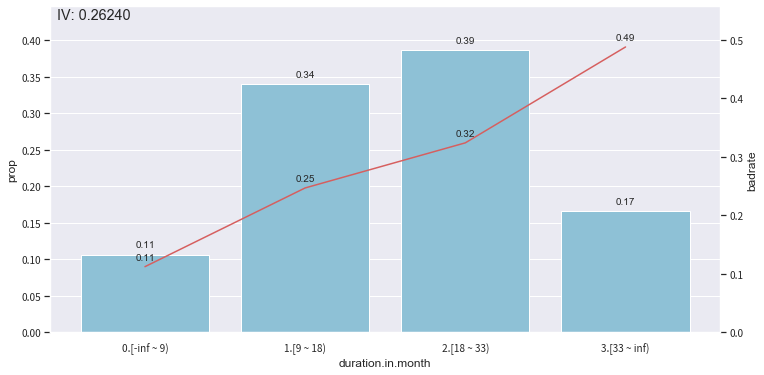

In [7]:
# Make adjustment to c2 and check bin_plot
c2.set_rules({'duration.in.month': [9, 18, 33]})
bin_plot(c2.transform(data_tr2[['duration.in.month','creditability']],labels=True),x='duration.in.month',target='creditability')

In [8]:
# if accpetable, update the adjustment to the original combiner and proceed
combiner.set_rules({'duration.in.month': [9, 18, 33]})

** **Combo: bin_plot() & badrate_plot()** ** : first use bin_plot() to fine tune bins for the  in-sample, then use badrate_plot() to check stability across OOT / test

No handles with labels found to put in legend.
No handles with labels found to put in legend.


{'purpose': [['domestic appliances'], ['car (used)'], ['retraining'], ['radio/television'], ['furniture/equipment'], ['repairs'], ['business'], ['car (new)'], ['education'], ['others']]}


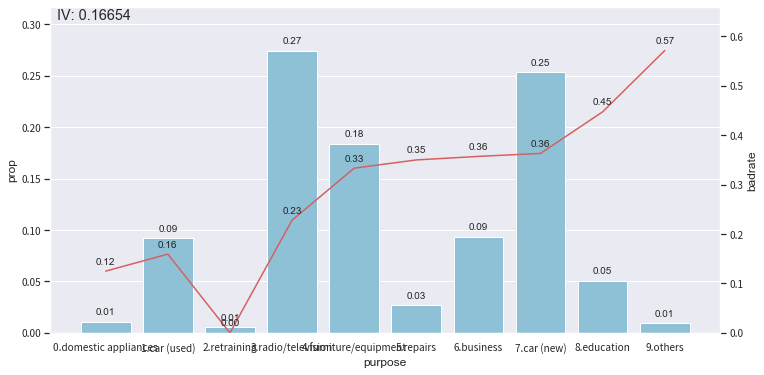

In [9]:
# Example with a categorical feature
c2 = toad.transform.Combiner()
c2.fit(data_tr2[['purpose','creditability']],y='creditability',method='chi')
bin_plot(c2.transform(data_tr2[['purpose','creditability']],labels=True),x='purpose',target='creditability')
print(c2.export())

No handles with labels found to put in legend.
No handles with labels found to put in legend.


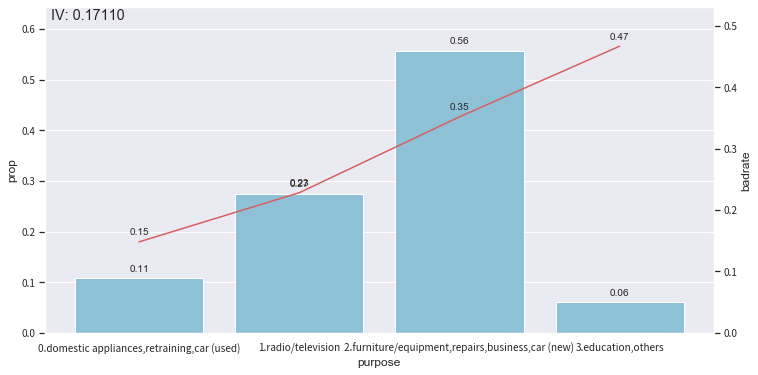

In [13]:
# Make adjustment to c2 and check bin_plot

# for categorical features, one can combine according to the bad_rate
c2.set_rules({'purpose': [['domestic appliances','retraining','car (used)'], ['radio/television'], ['furniture/equipment','repairs','business','car (new)'], ['education','others']]})
bin_plot(c2.transform(data_tr2[['purpose','creditability']],labels=True),x='purpose',target='creditability')

#combiner.set_rules({'purpose': [['domestic appliances','retraining','car (used)'], ['radio/television'], ['furniture/equipment','repairs','business','car (new)'], ['education','others']]})

** **Note: badrate_plot() is especially important to make sure the bins are stable across time** **

** **A comparison of different binning techniques** ** w/ an example of 'duration.in.month' and n_bins = 5. 

Remember the "no free lunch" rule, different binning techniques serve for different occasions. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


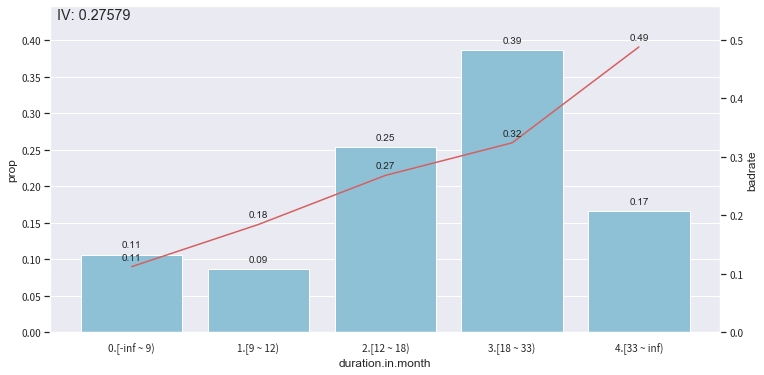

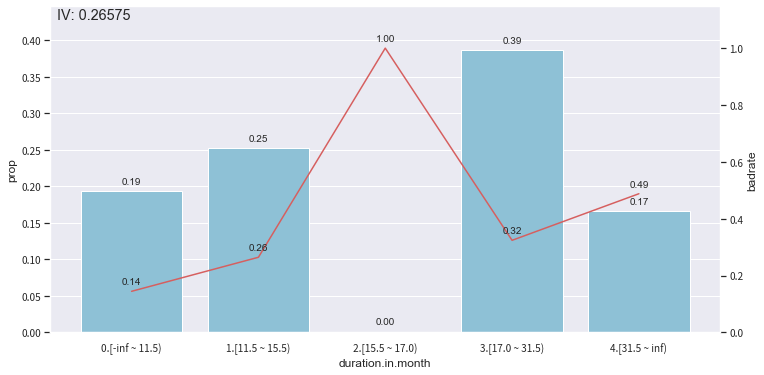

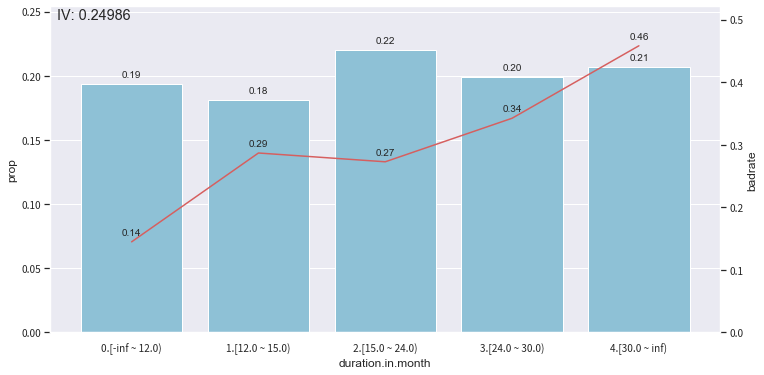

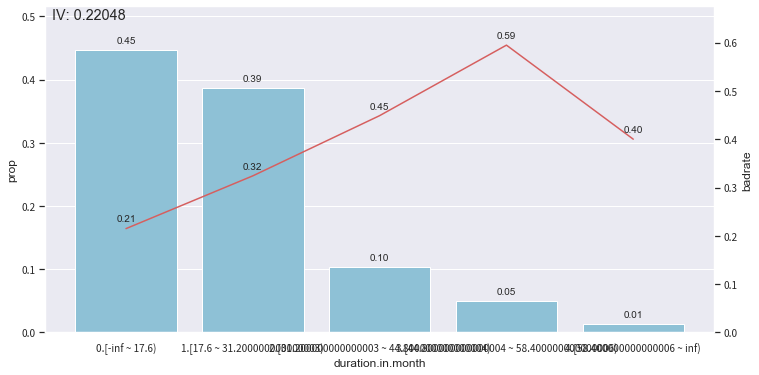

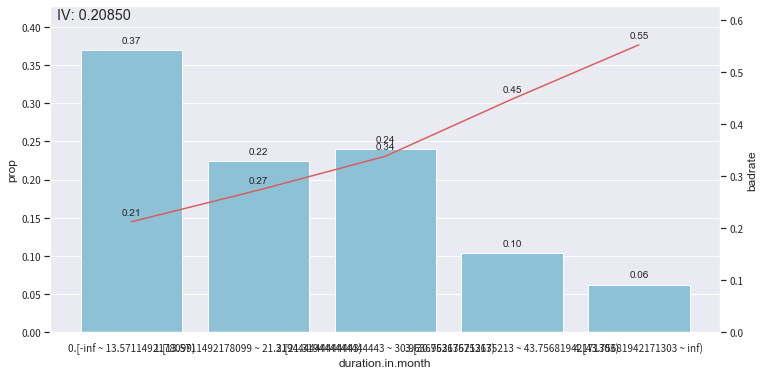

In [11]:
for method in ['chi','dt','quantile','step','kmeans']:
    c2 = toad.transform.Combiner()
    c2.fit(data_tr2[['duration.in.month','creditability']],y='creditability',method = method, n_bins=5)
    bin_plot(c2.transform(data_tr2,labels=True),x='duration.in.month',target='creditability')

### ### 2. Model validation
Typical for scorecard models, when a model is developed and its scores must be validated for OOT samples. 

**2.1 Scenario**: want to check if the predicted scores are stable across time or w/ test

** **Combo: combiner() & badrate_plot() for predicted probability** **:

(1) Fit a combiner() with training proability and quantile method. 

(2) Use the same cutting point for the test probaility. 

(3) If both the proportion and bad rates are stable, then the model is stable. 

In [14]:
# prepare a model for demo 

# automatic binning and WOE transformation
c = toad.transform.Combiner()
combiner.fit(data_tr,y='creditability',method='chi',min_samples =  0.07) 
t=toad.transform.WOETransformer()
data_tr_woe = t.fit_transform(data_tr,data_tr['creditability'], exclude=['creditability','type'])
data_ts_woe = t.transform(data_ts)

# fit a lr model
lr = LogisticRegression()
lr.fit(data_tr_woe.drop(['creditability','type'],axis=1),data_tr['creditability'])

# predict proabilities for train and test/OOT
pred_tr = lr.predict_proba(data_tr_woe.drop(['creditability','type'],axis=1))[:,1]
pred_ts = lr.predict_proba(data_ts_woe.drop(['creditability','type'],axis=1))[:,1]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


PSI: 1.0041286616972924


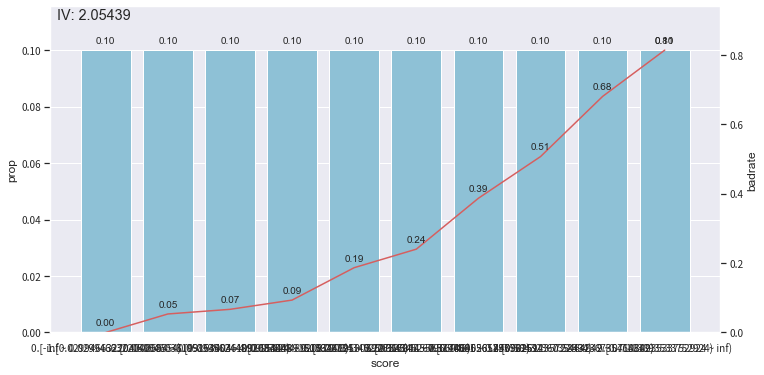

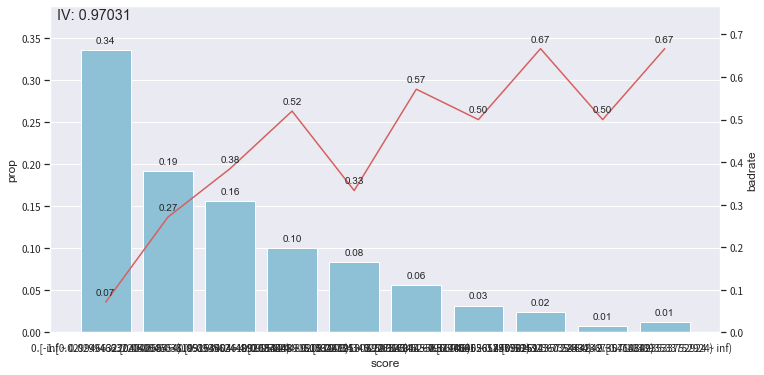

In [13]:
# concat the predicted score and target
pred_tr_df = pd.DataFrame({'score':pred_tr,'creditability': data_tr['creditability']})
pred_ts_df =pd.DataFrame({'score':pred_ts,'creditability': data_ts['creditability']})

# fit a combiner()
c4 = toad.transform.Combiner()
c4.fit(pred_tr_df,y='creditability',method='quantile',n_bins=10)

# plot bin_plot for both train and test/OOT
for data in [pred_tr_df,pred_ts_df]:
    bin_plot(c4.transform(data,labels=True),x='score',target='creditability')

# get the PSI for the score binning results.     
print('PSI:', toad.metrics.PSI(c4.transform(pred_tr_df,labels=True)['score'],c4.transform(pred_ts_df,labels=True)['score'])) 

**Takeaway from the plots**: the cutting points determined at the training are not reliable. The PSI is too high. Need to adjust model. 

### ### 3. Feature selection

**3.1 Scenario**: use PSI to check stability of binning. 

In [14]:
feautre_lst = list(Xtr.columns)

c4 = toad.transform.Combiner()
c4.fit(data_tr,y='creditability', method = 'chi',min_samples=0.05)

for feature in feautre_lst:
    psi_ = toad.metrics.PSI(c4.transform(data_tr[[feature,'creditability']]), c4.transform(data_ts[[feature,'creditability']]))
    print(psi_)

status.of.existing.checking.account    0.001251
creditability                          0.000545
dtype: float64
duration.in.month    0.038467
creditability        0.000545
dtype: float64
credit.history    0.012744
creditability     0.000545
dtype: float64
purpose          0.053175
creditability    0.000545
dtype: float64
credit.amount    0.000629
creditability    0.000545
dtype: float64
savings.account.and.bonds    0.012473
creditability                0.000545
dtype: float64
present.employment.since    0.031952
creditability               0.000545
dtype: float64
installment.rate.in.percentage.of.disposable.income    0.023651
creditability                                          0.000545
dtype: float64
personal.status.and.sex    0.001096
creditability              0.000545
dtype: float64
other.debtors.or.guarantors    0.000000
creditability                  0.000545
dtype: float64
present.residence.since    0.021920
creditability              0.000545
dtype: float64
property         0.

**3.2 Scenario: drop features for multicolleanerity**

toad.selection.drop_vif(df, threshold = 3, return_drop = False, exclude = None)

In [15]:
num_data = data_tr._get_numeric_data()
cleared_data, dropped =  toad.selection.drop_vif(num_data,threshold=10,return_drop=True)
dropped

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


['age.in.years']